In [1]:
from devito import *
from AI4Advection_Diffusion import PDE_Solver
from examples.cfd import  plot_field
import numpy as np
from filter.filter_generator import upwind, centre_difference
import torch
import matplotlib.pyplot as plt

## prepare data

torch.Size([1, 1, 256, 256])


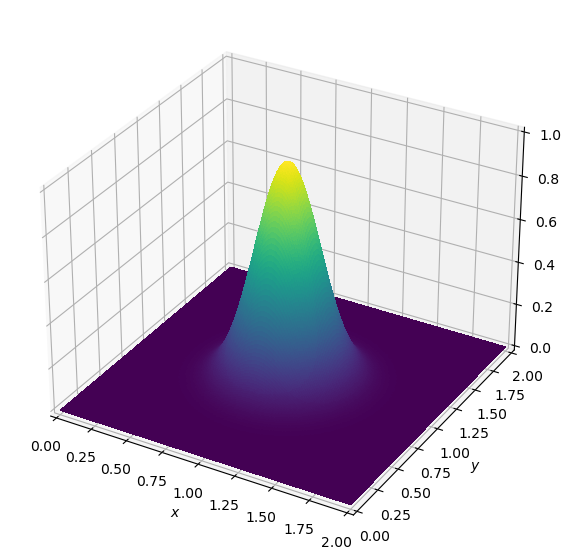

In [2]:

def init_smooth(field, dx, dy):
    nx, ny = field.shape
    x = np.linspace(0, (nx-1)*dx, nx)
    y = np.linspace(0, (ny-1)*dy, ny)
    X, Y = np.meshgrid(x, y, indexing='ij')
    
    # 使用高斯分布初始化平滑场
    sigma = 0.2
    field[:] = np.exp(-((X-nx*dx/2)**2 + (Y-ny*dy/2)**2) / (2*sigma**2))
    
nt = 100  # Number of timesteps
dt = 0.001  # Timestep size (sigma=0.2)
nx = 256
ny = 256
length = 2.
c = 1  # Value for c

# Then we create a grid and our function
grid = Grid(shape=(nx, ny), extent=(length, length))
u = TimeFunction(name='u', grid=grid,save = nt,time_order = 2, space_order = 2)
# We can now set the initial condition and plot it
init_smooth(field=u.data[0], dx=grid.spacing[0], dy=grid.spacing[1])
u_tensor_init_ad = torch.tensor(u.data[0], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
torch.save(u_tensor_init_ad[0,0,:,:].detach(),f'./pure_advection/AD0.pt')
print(u_tensor_init_ad.shape)
plot_field(u.data[0])


In [3]:
D = 0.01
eq = Eq(u.dt, D*u.laplace)
eq

Eq(Derivative(u(time, x, y), time), 0.01*Derivative(u(time, x, y), (x, 2)) + 0.01*Derivative(u(time, x, y), (y, 2)))

In [4]:
dx = length/nx
dy = length/ny
if dt <= dx**2*dy**2/(2*D*(dx**2+dy**2)):
    print('dt is smaller than',dx**2*dy**2/(2*D*(dx**2+dy**2)))
else:
    print('dt is larger than',dx**2*dy**2/(2*D*(dx**2+dy**2)),'choose dt again')
    


dt is smaller than 0.00152587890625


## Diffusion model

In [5]:

model_diff = PDE_Solver(eq = eq,u = u, dx = length/nx, dy = length/ny, nx = nx, ny = ny,dt = dt, solver = centre_difference)

In [6]:
model_diff.A

tensor([[[[ 0.0000, -0.1638,  0.0000],
          [-0.1638,  0.0000, -0.1638],
          [ 0.0000, -0.1638,  0.0000]]]])

In [7]:
model_diff.forward(4)

tensor([[[[0.0000e+00, 2.6153e-10, 3.7175e-08,  ..., 8.7264e-08,
           4.6249e-08, 4.5956e-08],
          [2.6153e-10, 5.2311e-10, 3.7437e-08,  ..., 8.7557e-08,
           4.6543e-08, 4.6249e-08],
          [3.7175e-08, 3.7437e-08, 7.4377e-08,  ..., 1.2862e-07,
           8.7572e-08, 8.7279e-08],
          ...,
          [8.7264e-08, 8.7557e-08, 1.2862e-07,  ..., 1.8899e-07,
           1.4336e-07, 1.4303e-07],
          [4.6249e-08, 4.6543e-08, 8.7572e-08,  ..., 1.4336e-07,
           9.7770e-08, 9.7441e-08],
          [4.5956e-08, 4.6249e-08, 8.7279e-08,  ..., 1.4303e-07,
           9.7441e-08, 9.7112e-08]]]], grad_fn=<DivBackward0>)

### Data generation

In [8]:

for i in range(1,nt):
    model_diff =  PDE_Solver(eq = eq,u = u, dx = length/nx, dy = length/ny, nx = nx, ny = ny,dt = dt, solver=centre_difference, omega = 1.5)
    result = model_diff.forward(4)
    result = (result - result.min())/(result.max() - result.min())
    u.data[0] = result[0,0,:,:].detach().numpy()
    torch.save(result[0,0,:,:].detach(),f'./diffusion_equation_result/DF{i}.pt')

### virtualization

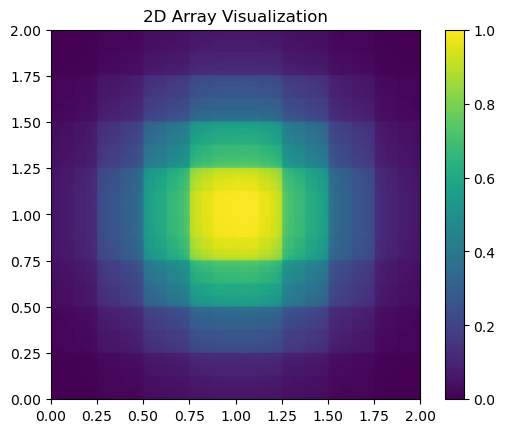

In [9]:
import matplotlib.pyplot as plt
test = torch.load('./diffusion_equation_result/DF10.pt')
# centre = test[1:-1,1:-1]
# centre = (centre-centre.min()) / (centre.max() - centre.min())
plt.imshow(test.numpy(), extent=(0, 2, 0, 2), origin='lower', cmap='viridis')
plt.colorbar()  
plt.title("2D Array Visualization")
plt.show()

In [10]:
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# 加载张量数据
tensors = []
for i in range(1, nt):
    tensor = torch.load(f'./diffusion_equation_result/DF{i}.pt')
    tensors.append(tensor)

# 创建动画
fig, ax = plt.subplots()
def update(frame):
    global cbar
    ax.clear()
    data = tensors[frame].detach().numpy()
    cax = ax.imshow(data, cmap='viridis', origin='lower',extent=(0,2,0,2))
    ax.set_title(f'Timestep {frame}')
    return cax

anim = FuncAnimation(fig, update, frames=len(tensors), interval=200, blit=False)

# 显示动画
plt.close(fig)  # 防止显示静态图
HTML(anim.to_jshtml())

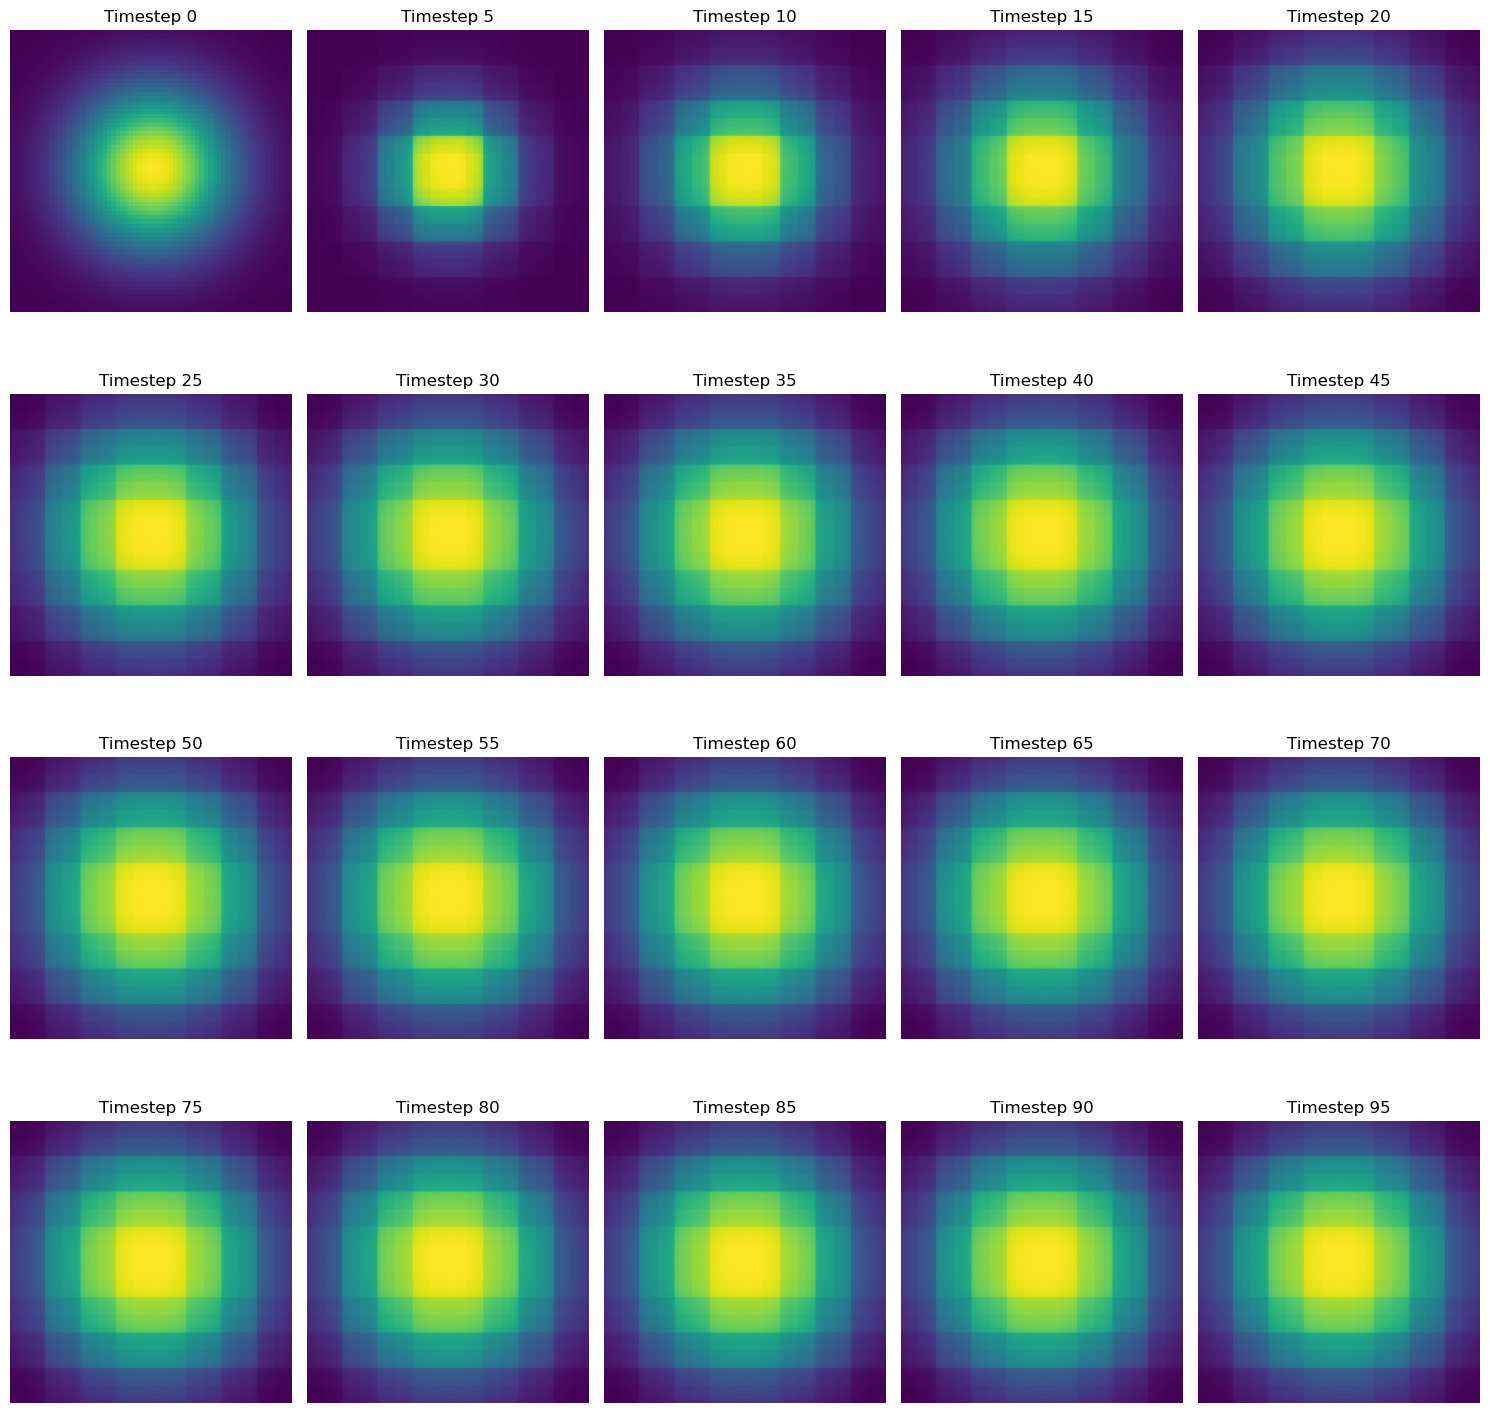

In [11]:
tensors = []
for i in range(0, nt, 5):
    tensor = torch.load(f'./diffusion_equation_result/DF{i}.pt')
    tensors.append(tensor)

fig, axes = plt.subplots(nrows=len(tensors)//5, ncols=5, figsize=(15, 15))

for idx, tensor in enumerate(tensors):
    ax = axes[idx // 5, idx % 5]
    data = tensor.detach().numpy()
    ax.imshow(data, cmap='viridis', origin='lower')
    ax.set_title(f'Timestep {idx*5}')
    ax.axis('off')  

plt.tight_layout()
plt.show()